<a href="https://colab.research.google.com/github/josebendana/Smart-Tools/blob/main/Tensorflow_Lite_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the Smartool github repository and the plotting utils repository

In [ ]:
! git clone https://github.com/UTAustin-SwarmLab/SmartTools.git
! git clone https://github.com/UTAustin-SwarmLab/plotting_utils.git

Cloning into 'SmartTools'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 399 (delta 10), reused 31 (delta 10), pack-reused 368
Receiving objects: 100% (399/399), 3.35 MiB | 15.17 MiB/s, done.
Resolving deltas: 100% (237/237), done.
Cloning into 'plotting_utils'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.


Import Libraries

In [1]:
import pandas as pd
import sys,os
from collections import OrderedDict
import argparse
import numpy as np
import datetime
import io
import tensorflow as tf


2023-04-05 16:20:04.791827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 16:20:05.100825: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/usr/lib/x86_64-linux-gnu/libEGL_nvidia.so.470.86
2023-04-05 16:20:05.100846: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 16:20:06.115455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; d

Define where the base code is on the machine

In [ ]:
# "!mkdir" creates a folder or directory that appears on the folders tab in google colab
!mkdir  SMART_TOOLS_ROOT_DIR
!mkdir  SMART_TOOLS_ROOT_DIR/scratch/
!mkdir  SMART_TOOLS_ROOT_DIR/scratch/base_dir
!mkdir  UTILS_DIR
!mkdir  SMART_TOOLS_ROOT_DIR/scratch/base_dir/tf_model

# The folder path strings are matched with their corresponding variables
model_base_dir='SMART_TOOLS_ROOT_DIR/scratch/base_dir/tf_model'
base_dir='SMART_TOOLS_ROOT_DIR/scratch/base_dir'


Helper function to extract key columns in numpy format from data frame

In [2]:
def get_xy_numpy(df, x_features_columns, y_features_columns='Activity'):
    x_df = df[x_features_columns]
    x_np = x_df.to_numpy()
    # get the output column we want to predict
    y_df = df[y_features_columns]
    y_np = y_df.to_numpy()
    # assert the x and y dataframes do NOT have any null or NaN entries
    assert(x_df.isnull().sum().sum() == 0)
    assert(y_df.isnull().sum().sum() == 0)

    return x_np, y_np, x_df, y_df

In [3]:
# how many samples are taken at once for training
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

epochs = 50

# NOTE: data will be re-organized to size:
# BATCH_SIZE x NUM_SENSORS x NUM_FEATURES
# view this as an image with 1 channel, NUM_SENSORS x NUM_FEATURES size

In [ ]:
# RUN THIS ON COLAB || NEXT CELL FOR LOCAL
#Files allows the user to run the code block and be prompted for the file location on the local device
from google.colab import files
uploaded = files.upload()

#Three separate datasets are uploaded: Train, Validate and Test
val_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv']))
train_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Train_Xy_Matrix.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Test_Xy_Matrix.csv']))


print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_df.describe())
print(train_df['Activity'].value_counts())
num_activities = len(set(train_df['Activity']))

Saving OL50_10secframe_Proccessed_Test_Xy_Matrix.csv to OL50_10secframe_Proccessed_Test_Xy_Matrix.csv
Saving OL50_10secframe_Proccessed_Train_Xy_Matrix.csv to OL50_10secframe_Proccessed_Train_Xy_Matrix.csv
Saving OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv to OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv
(2160, 114)
(2160, 114)
(3240, 114)
        Unnamed: 0     accX_min     accX_max    accX_mean    accX_kurt  \
count  2160.000000  2160.000000  2160.000000  2160.000000  2160.000000   
mean   1079.500000    -6.501107     2.560226    -1.684601     8.411726   
std     623.682612    26.200708    15.183595     5.893925    19.169999   
min       0.000000  -724.121094   -21.350098   -38.897365    -1.914826   
25%     539.750000    -2.773071     0.000000    -0.845020    -0.024499   
50%    1079.500000    -1.551941     0.680664    -0.343017     1.693832   
75%    1619.250000    -0.833862     1.833466    -0.011254     5.967497   
max    2159.000000     0.018799   316.833496     4.87342

In [88]:
# RUN THIS ON LOCAL

# Yaswaka
val_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/Yaskawa_Validate_Xy_Matrix.csv')
train_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/Yaskawa_Train_Xy_Matrix.csv')
test_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/Yaskawa_Test_Xy_Matrix.csv')

# F21 human
# val_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv')
# train_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/OL50_10secframe_Proccessed_Train_Xy_Matrix.csv')
# test_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/OL50_10secframe_Proccessed_Test_Xy_Matrix.csv')


print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_df.describe())
print(train_df['Activity'].value_counts())
num_activities = len(set(train_df['Activity']))

(2331, 113)
(2334, 113)
(2002, 113)
       Unnamed: 0.1   Unnamed: 0     accX_min     accX_max    accX_mean  \
count   2331.000000  2331.000000  2331.000000  2331.000000  2331.000000   
mean    1165.000000  1278.788932    -1.150260    -0.188074    -0.621881   
std      673.046061   853.905863     0.663173     0.757340     0.446240   
min        0.000000     0.000000    -3.999512    -0.996094    -1.085992   
25%      582.500000   582.500000    -1.263855    -0.845825    -1.016267   
50%     1165.000000  1165.000000    -1.113159    -0.389282    -0.734740   
75%     1747.500000  1857.500000    -0.756348     0.302856     0.014627   
max     2330.000000  3665.000000     0.030762     3.999512     0.082291   

         accX_kurt     accX_sem     accX_std     accX_var    accX_skew  ...  \
count  2331.000000  2331.000000  2331.000000  2331.000000  2331.000000  ...   
mean     26.348862     0.002420     0.077623     0.012406    -0.245969  ...   
std      79.504865     0.002488     0.079895     0.

Store the dataframes into a dictionary called "train_test_val_df_dict"


In [89]:
# get all columns that are inputs to our model (anything thats not labels or unnamed)
x_features_columns = [colname for colname in list(train_df) if colname not in ['Unnamed: 0', 'Activity', 'Subject Number', 'Trial', 'Unnamed: 0.1']]
y_features_columns = 'Activity'

# repeat key column extraction for train and val data

train_test_val_df_dict = OrderedDict()
train_test_val_df_dict['train'] = train_df
train_test_val_df_dict['val'] = val_df
train_test_val_df_dict['test'] = test_df

tf_dataset_dict = OrderedDict()

# min, max, mean etc.
num_features = 10
num_sensors = int(len(x_features_columns)/num_features)

In [90]:
# SCALE THE DATA and create a Tensorflow DataSet
# analagous to a Pytorch data loader
# KEY POINT: we manually re-scale without sklearn so we know how to replicate the scaling in C on the Arduino
# we store the scaling quantiles in train_quantile_csv, saved later

for data_split, data_df in train_test_val_df_dict.items():

    data_x_np, data_y_np, data_x_df, data_y_df = get_xy_numpy(data_df, x_features_columns, y_features_columns=y_features_columns)

    quantile_list = [.001, 0.25, 0.5, 0.75, 0.999]


    # only for training data, get the above quantiles for ALL COLUMNS and save to a csv
    if data_split == 'train':
        # do not use sklearn, instead save the following quantiles of data to a dataframe and store as a csv
        train_quantile_df = data_x_df.quantile(quantile_list)
        # train_quantile_df.to_csv('/home/ss26/Projects/Smart-Tools/notebooks/outputs/yaskawa/train_normalization_quantiles.csv')

    # for all data, scale each column using the same PER-COLUMN scaling as the training data for uniformity
    normalized_data_x_df = data_x_df.copy()
    for feature_name in data_x_df.columns:

        # do not use absolute min, max due to OUTLIERS!
        min_value = train_quantile_df[feature_name][quantile_list[0]]
        max_value = train_quantile_df[feature_name][quantile_list[-1]]

        normalized_data_x_df[feature_name] = (data_x_df[feature_name] - min_value) / (max_value - min_value)

    # now, print the stats of the normalized dataframe, the max should be roughly near 1 always
    print(' ')
    print(' ')
    print('data split: ', data_split)
    print(normalized_data_x_df.describe())
    print(' ')
    print(' ')

  ## now actually transform the training data
    data_x_np_scaled = normalized_data_x_df.to_numpy()

    ## BATCH_SIZE x NUM_SENSORS x NUM_FEATURES
    ## view this as an image with 1 channel, NUM_SENSORS x NUM_FEATURES size

    reshaped_data_x_np_scaled = data_x_np_scaled.reshape([-1, num_sensors, num_features])

    ## get a tensorflow dataset
    tf_dataset = tf.data.Dataset.from_tensor_slices((reshaped_data_x_np_scaled, data_y_np))

    # load the tensorflow dataset
    tf_dataset_dict[data_split] = tf_dataset

 
 
data split:  train
          accX_min     accX_max    accX_mean    accX_kurt     accX_sem  \
count  2331.000000  2331.000000  2331.000000  2331.000000  2331.000000   
mean      0.712400     0.160020     0.396585     0.036672     0.108326   
std       0.165814     0.151913     0.382937     0.103175     0.113172   
min       0.000000    -0.002059    -0.001687    -0.000004    -0.000088   
25%       0.683998     0.028083     0.058147     0.003919     0.038032   
50%       0.721676     0.119660     0.299737     0.007988     0.069510   
75%       0.810890     0.258495     0.942799     0.023486     0.127221   
max       1.007691     1.000000     1.000864     1.331684     1.101096   

          accX_std      accX_var    accX_skew     accX_mad     accX_sum  ...  \
count  2331.000000  2.331000e+03  2331.000000  2331.000000  2331.000000  ...   
mean      0.107744  2.457994e-02     0.225610     0.144353     0.401100  ...   
std       0.112679  7.575436e-02     0.107439     0.120178     0.38226

In [91]:
# we now have all the datasets and dataloaders in TENSORFLOW format
train_data = tf_dataset_dict['train'].shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data = tf_dataset_dict['val'].batch(BATCH_SIZE)
test_data = tf_dataset_dict['test'].batch(BATCH_SIZE)

# find the number of batches in the TESTING dataset
# this is useful later
test_len = 0
for batch in test_data:
    test_len += 1

In [8]:
def build_1D_CNN(model_base_dir, model_name = '1DCNN', num_sensors = 11, num_features = 10, num_outputs = 4):

  """Builds a convolutional neural network in Keras."""
  model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(56, 3, activation='relu', input_shape=(num_sensors, num_features)),
        tf.keras.layers.MaxPooling1D(2, 2),
        tf.keras.layers.Conv1D(56, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(num_outputs, activation='softmax')])

  model_path = None

  #model_path = os.path.join(model_base_dir + "./netmodels", "1DCNN")
  #print("Built CNN.")
  #if not os.path.exists(model_path):
  #  os.makedirs(model_path)
  #model.load_weights(model_base_dir + "./netmodels/1DCNN/weights.h5")

  return model, model_path

In [9]:
def calculate_model_size(model):
  print(model.summary())
  var_sizes = [
      np.product(list(map(int, v.shape))) * v.dtype.size
      for v in model.trainable_variables
  ]
  model_size = sum(var_sizes) / 1024

  print("Model size:", model_size, "KB")
  return model_size

In [15]:
# 1D CNN model
model_base_dir = '/home/ss26/Projects/Smart-Tools/notebooks/outputs/yaskawa/model'
base_dir = '/home/ss26/Projects/Smart-Tools/notebooks/outputs/yaskawa'
model, model_path = build_1D_CNN(model_base_dir, model_name = '1DCNN', num_sensors = num_sensors, num_features = num_features, num_outputs = num_activities)

# How many KB is the final tensorflow model?
model_size = calculate_model_size(model)

# when we train, we save a csv of the training accuracy/loss
csv_logger = tf.keras.callbacks.CSVLogger(base_dir + '/training.log')

# how long we train, set up model with loss function
# do 50 for convergence, do 5 to test code
model.compile(optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

# needs a bit more debugging for confusion matrix (later)
#test_labels = np.zeros(test_len)
#idx = 0
#for data, label in test_data:  # pylint: disable=unused-variable
#    test_labels[idx] = label.numpy()
#    idx += 1

# now, finally start training
model.fit(train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[csv_logger])

# test loss, test accuracy
loss, acc = model.evaluate(test_data)
pred = np.argmax(model.predict(test_data), axis=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 9, 56)             1736      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 4, 56)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 56)             9464      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 56)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 56)                0         
                                                                 
 dense_4 (Dense)             (None, 784)              

In [16]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 9, 56)             1736      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 4, 56)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 56)             9464      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 56)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 56)                0         
                                                                 
 dense_4 (Dense)             (None, 784)              

In [18]:
# now lets quantize the model for the arduino
#####################################################################


# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = model_base_dir + '/model.tflite'

# Save the model to disk
open(tflite_model_path, "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_quantized_model_path = model_base_dir + '/model_quantized.tflite'

# Save the model to disk
open(tflite_quantized_model_path, "wb").write(tflite_model)

basic_model_size = os.path.getsize(tflite_model_path) / 1024.0
print("Basic model is %d Kilobytes" % basic_model_size)
quantized_model_size = os.path.getsize(tflite_quantized_model_path) / 1024.0
print("Quantized model is %d Kilobytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d Kilobytes" % difference)

INFO:tensorflow:Assets written to: /tmp/tmp4w8po3rm/assets


INFO:tensorflow:Assets written to: /tmp/tmp4w8po3rm/assets
2023-04-05 16:26:12.471831: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-05 16:26:12.471869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-05 16:26:12.472033: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4w8po3rm
2023-04-05 16:26:12.473393: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-05 16:26:12.473410: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4w8po3rm


INFO:tensorflow:Assets written to: /tmp/tmp27fkf37n/assets


INFO:tensorflow:Assets written to: /tmp/tmp27fkf37n/assets


Basic model is 236 Kilobytes
Quantized model is 67 Kilobytes
Difference is 168 Kilobytes


2023-04-05 16:26:13.787325: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-05 16:26:13.787361: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-05 16:26:13.787492: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp27fkf37n
2023-04-05 16:26:13.788468: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-05 16:26:13.788481: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp27fkf37n


In [59]:
x = np.concatenate([x for x,y in test_data], axis=0)
# np.save('test_data_x_np', x, allow_pickle=True)
y = np.concatenate([y for x,y in test_data], axis=0)
# np.save('test_data_y_np', y, allow_pickle=True)

In [99]:
inf_df = test_df.copy()
y_true = inf_df['Activity'].to_numpy()

y_pred = np.argmax(model.predict(test_data), axis=1)

32/32 [==============================] - 0s 916us/step


In [100]:

confidence = model.predict(test_data)
type(confidence)
confidence.shape, y_true.shape
# confidence = confidence.max(axis=1)
confidence

32/32 [==============================] - 0s 879us/step


array([[9.9950880e-01, 1.9313385e-08, 4.5506180e-08, 4.9113791e-04],
       [9.9236929e-01, 2.2573220e-06, 4.7437106e-06, 7.6236450e-03],
       [9.9750841e-01, 2.7613029e-07, 5.5169130e-07, 2.4907098e-03],
       ...,
       [7.0881640e-07, 2.5789652e-04, 5.4597029e-05, 9.9968690e-01],
       [8.4970006e-06, 1.4720540e-04, 1.8260772e-04, 9.9966168e-01],
       [1.0719663e-02, 3.1414221e-04, 2.8802658e-04, 9.8867816e-01]],
      dtype=float32)

In [102]:
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss

precision = precision_score(y_true, y_pred, average='micro')
precision

logloss = log_loss(y_true, confidence)
logloss


0.09942710092536107

In [81]:
y_pred

array([2, 2, 2, ..., 2, 2, 2])

In [70]:
loss, acc = model.evaluate(test_data)

51/51 [==============================] - 0s 1ms/step - loss: 105935560704.0000 - accuracy: 0.4488


In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

def plot_cf(y_true, y_pred, title_suffix):
  cm = confusion_matrix(y_true, y_pred)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  ax.set_title('Confusion Matrix' + title_suffix)
  ax.set_xlabel('Predicted Activity')
  ax.set_xticklabels(['Engrave', 'Cut', 'Sand', 'Route'])
  ax.set_ylabel('True Activity')
  ax.set_yticklabels(['Engrave', 'Cut', 'Sand', 'Route'])
  ax.legend([])
  plt.show()

def accuracy(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
  return cm.diagonal()

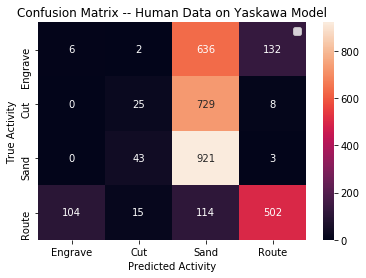

In [85]:
plot_cf(y_true, y_pred, ' -- Human Data on Yaskawa Model')

In [35]:
acc_pc = accuracy(y_true, y_pred)
sum(acc_pc)/4

0.4189909378689751

### Generate a TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [ ]:
!apt-get update && apt-get -qq install xxd

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [903 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

Grab the "model.tflite_quantized" generated in the previous step that was saved into: "/content/SMART_TOOLS_ROOT_DIR/scratch/base_dir/tf_model/model_quantized.tflite"

In [ ]:
MODEL_TFLITE = '/content/SMART_TOOLS_ROOT_DIR/scratch/base_dir/tf_model/model_quantized.tflite'
MODEL_TFLITE_MICRO = 'model_quantized.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE! **So don't close this Colab as we'll use the model printout in the next step of the deployment to the Arduino IDE!**

In [ ]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x48, 0x0e, 0x01, 0x00, 0xc8, 0xf4, 0x00, 0x00, 0xb0, 0xf4, 0x00, 0x00,
  0xb0, 0x00, 0x00, 0x00, 0x78, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x46, 0x08, 0xff, 0xff,
  0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xbc, 0xff, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00,
  0x1d, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x31, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x0a, 0x0b, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x63, 0x

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))